In [1]:
# Packages that need installing on startup

#!pip install ipywidgets

#if there are futher issues with librosa complaining about sndfile on import, run the following
#!apt-get -y update && apt-get -y install libsndfile1

In [72]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import IPython.display as ipd
import librosa as lb 
# Issue with installing librosa, using wavfile for visualization instead
#import ipywidgets as widgets

from scipy.io import wavfile
from sklearn.model_selection import StratifiedShuffleSplit
from pathlib import Path

import scipy

import tsfresh

# pip3 install shap

plt.rcParams['figure.figsize'] = [12, 8]

In [2]:
# Setup relative data paths, will need to be changed if running in deepnote

RAW_FOLDER = "../data/raw"
METADATA_FOLDER = "../data/metadata"
PROCESSED_FOLDER = "../data/processed"


In [3]:
df = pd.read_excel(f"{METADATA_FOLDER}/Age-sex calls- Dzanga Bai.xlsx",sheet_name="context")
df.head()

,unique_ID,call_type,comb,in_analysis,final_cat,final_subcat,distress,age,sex,agsex
0,opp_330_ru,ru,n,y,nrs,nrs,na,juv,un,un
1,opp_332_ru,ru,n,y,logistics,leave,na,ad,f,adf
2,opp_333_ru,ru,n,y,unspecific,unspecific,na,ad,f,adf
3,opp_333_ru1,ru,n,y,unspecific,unspecific,na,ad,f,adf
4,opp_333_ru2,ru,n,y,unspecific,unspecific,na,ad,f,adf


## Missingness by strata

In [4]:
n_records = len(df)
print(n_records)

valid_age = len(df[df.age != "un"]) / n_records 
valid_sex = len(df[df.sex != "un"]) / n_records 
valid_agsex = len(df[df.agsex != "un"]) / n_records 
print(f"Proportion of data available: \nAge: {valid_age}\nSex: {valid_sex}\nAgeSex: {valid_agsex}")

389
Proportion of data available: 
Age: 0.910025706940874
Sex: 0.8766066838046273
AgeSex: 0.8483290488431876


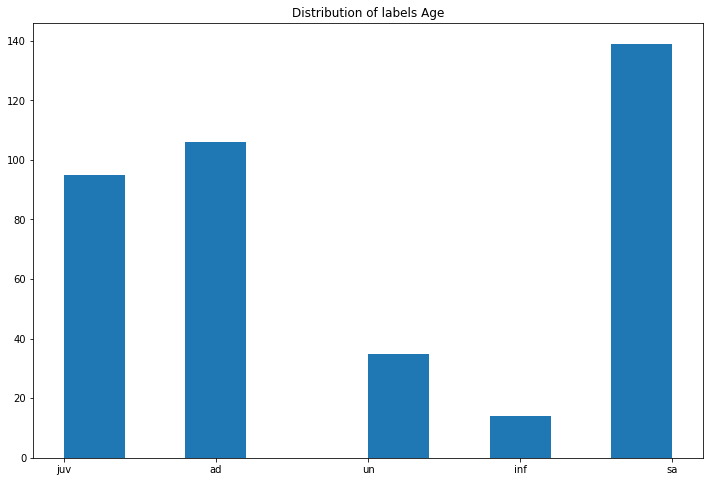

In [5]:
plt.hist(df.age)
plt.title("Distribution of labels Age")
plt.show()

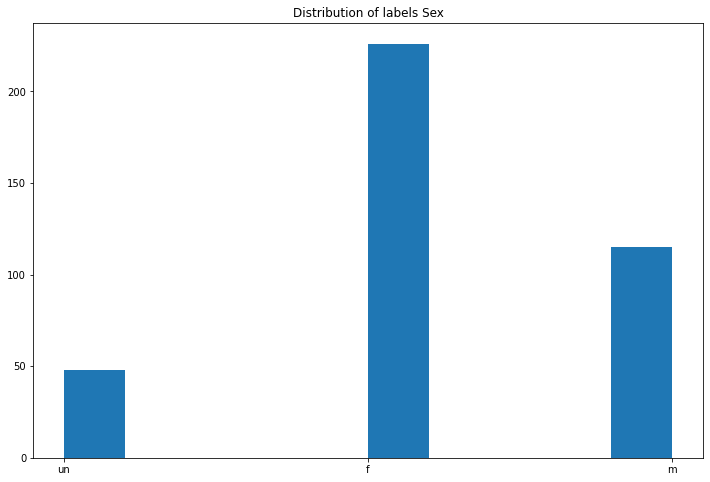

In [6]:
plt.hist(df.sex)
plt.title("Distribution of labels Sex")
plt.show()

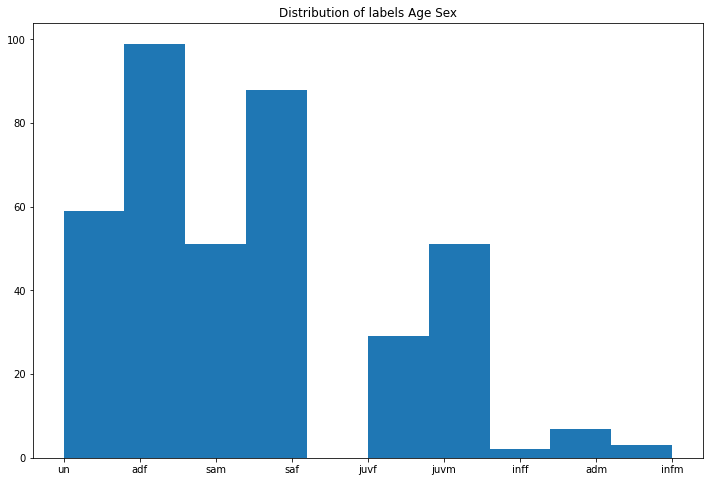

In [7]:
plt.hist(df.agsex)
plt.title("Distribution of labels Age Sex")
plt.show()

In [8]:
y = df.age.values
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

for train_idx, test_idx in sss.split(np.zeros(len(y)), y):
    y_train=y[train_idx]
    y_test=y[test_idx]

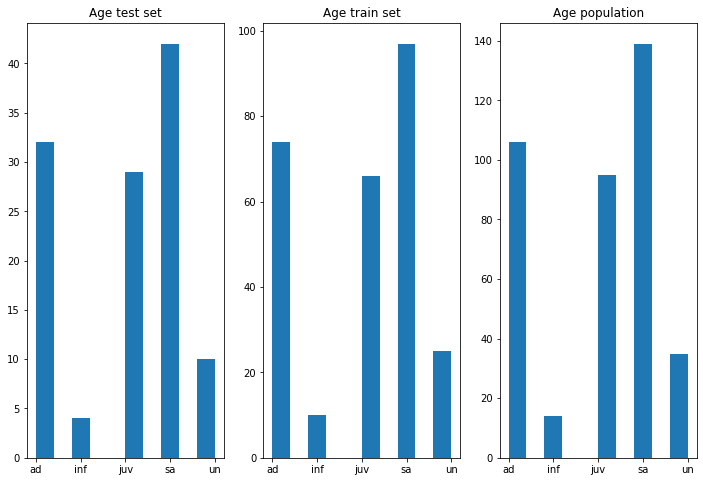

In [9]:
plt.subplot(1, 3, 1)
plt.title("Age test set")
plt.hist(sorted(y_test))
plt.subplot(1, 3, 2)
plt.title("Age train set")
plt.hist(sorted(y_train))
plt.subplot(1, 3, 3)
plt.title("Age population")
plt.hist(sorted(y))
plt.show()

## Creating spectograms

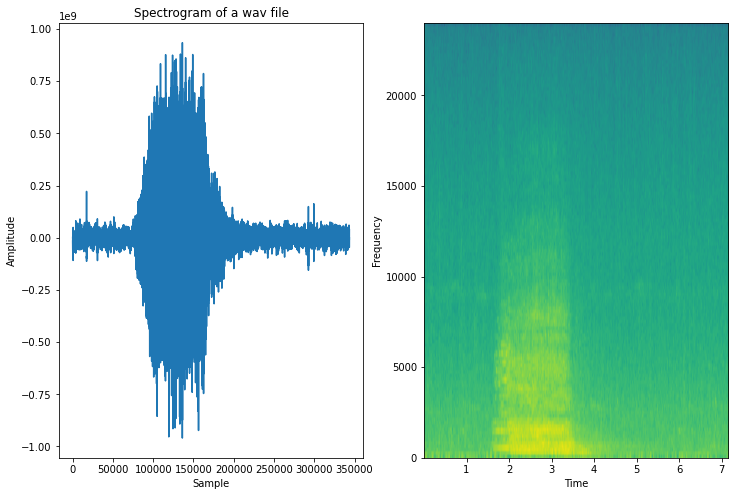

In [10]:
# Testing with a single wav file
audio_data = f'{RAW_FOLDER}/opp_329_ro.wav'
#
#ipd.Audio(audio_data,rate=60)

samplingFrequency, signalData = wavfile.read(audio_data)

# Plot the signal read from wav file

plt.subplot(121)
plt.title('Spectrogram of a wav file')
plt.plot(signalData)
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(122)
plt.specgram(signalData,Fs=samplingFrequency)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

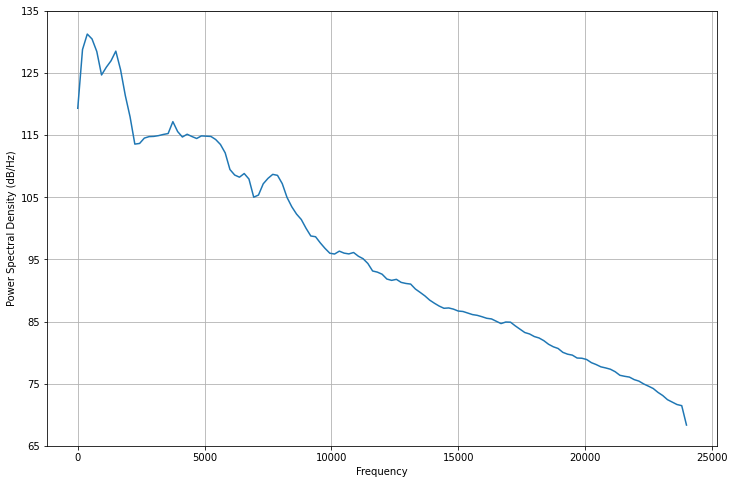

In [54]:
Density, freqs = plt.psd(signalData,Fs=samplingFrequency)

In [83]:
def spectral_statistics(y: np.ndarray, fs: int):
    """
    Compute mean frequency

    :param y: 1-d signal
    :param fs: sampling frequency [Hz]
    :return: mean frequency
    """
    spec = np.abs(np.fft.rfft(y))
    freq = np.fft.rfftfreq(len(y), d=1/fs)    
    amp = spec / spec.sum()
    mean = (freq * amp).sum()
    return mean 

In [158]:
def make_series(signalData, samplingFrequency, bin_value):
    freq_list = []
    time_list = []
    bin = bin_value
    for i in range(int(len(signalData)/samplingFrequency*bin)):
        freq_list.append(spectral_statistics(signalData[i*int(samplingFrequency/bin):(i+1)*int(samplingFrequency/bin)], samplingFrequency))
        time_list.append(i*(1/bin))
    return freq_list, time_list

In [ ]:
frequency_dataset

In [ ]:
bin_v = 50

In [159]:
freq_list, time_list = make_series(signalData, samplingFrequency, bin_v)

Text(0, 0.5, 'Frequency in Hz')

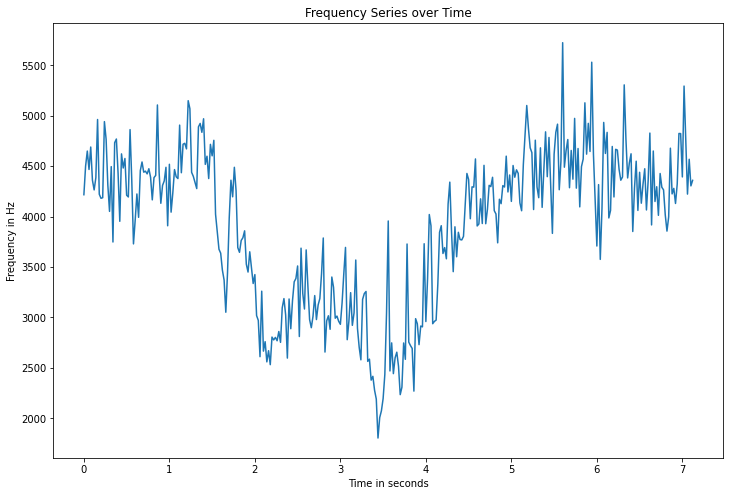

In [161]:
plt.plot(time_list, freq_list)
plt.title('Frequency Series over Time')
plt.xlabel('Time in seconds')
plt.ylabel('Frequency in Hz')

In [164]:
second_list = []
id_list = []
for i in range(len(time_list)):
    second_list.append(time_list[i])
    id_list.append('opp_329_ro.wav')

In [165]:
df = pd.DataFrame(list(zip(id_list, second_list, freq_list)), columns=["id","second", "frequency"])

df

# def smoothing(df):
#     lag_1 = df['signal'].shift(1)
#     lag_2 = df['signal'].shift(2)
#     lag_3 = df['signal'].shift(3)
#     lag_4 = df['signal'].shift(4)
#     lag_5 = df['signal'].shift(5)
#     lag_6 = df['signal'].shift(6)
#     lag_7 = df['signal'].shift(7)
#     lag_8 = df['signal'].shift(8)
#     lag_9 = df['signal'].shift(9)

#     df_new = pd.concat([df, lag_1, lag_2, lag_3, lag_4, lag_5, lag_6, lag_7, lag_8, lag_9], axis=1)
#     column_name_list = ["id","count", "signal", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_8", "lag_9"]
#     df_new.columns = column_name_list
#     df_new['avg'] = df_new[column_name_list[2:]].mean(axis=1)
#     df_new_return = df_new[['id', 'count', 'avg']]
#     df_new_rename = df_new_return.rename(columns={'avg': 'signal'})
#     return df_new_rename.iloc[::10, :]

# smoothed_df = smoothing(count_df)

# smoothed_df

# # lag_1 = count_df['signal'].shift(1)
# lag_2 = count_df['signal'].shift(2)
# lag_3 = count_df['signal'].shift(3)
# lag_4 = count_df['signal'].shift(4)
# lag_5 = count_df['signal'].shift(5)
# lag_6 = count_df['signal'].shift(6)
# lag_7 = count_df['signal'].shift(7)
# lag_8 = count_df['signal'].shift(8)
# lag_9 = count_df['signal'].shift(9)
# count_df_new=pd.concat([count_df, lag_1, lag_2, lag_3, lag_4, lag_5, lag_6, lag_7, lag_8, lag_9], axis=1)

# column_name_list = ["id","count", "signal", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_8", "lag_9"]
# count_df_new.columns = column_name_list
# count_df_new['avg'] = count_df_new[column_name_list[2:]].mean(axis=1)
# count_df_new

,id,second,frequency
0,opp_329_ro.wav,0.00,4216.626184
1,opp_329_ro.wav,0.02,4500.161370
2,opp_329_ro.wav,0.04,4649.292587
3,opp_329_ro.wav,0.06,4466.912234
4,opp_329_ro.wav,0.08,4689.342553
...,...,...,...
352,opp_329_ro.wav,7.04,4767.353783
353,opp_329_ro.wav,7.06,4222.759494
354,opp_329_ro.wav,7.08,4568.096111
355,opp_329_ro.wav,7.10,4304.255450


In [166]:
# --------------------------------------------------
# TSFresh Feature Extraction - takes about 15 mins
# --------------------------------------------------

extracted_features = tsfresh.extract_features(df, column_id="id", column_sort="second")

Feature Extraction: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.13s/it]


In [167]:
extracted_features

,frequency__variance_larger_than_standard_deviation,frequency__has_duplicate_max,frequency__has_duplicate_min,frequency__has_duplicate,frequency__sum_values,frequency__abs_energy,frequency__mean_abs_change,frequency__mean_change,frequency__mean_second_derivative_central,frequency__median,...,frequency__permutation_entropy__dimension_5__tau_1,frequency__permutation_entropy__dimension_6__tau_1,frequency__permutation_entropy__dimension_7__tau_1,frequency__query_similarity_count__query_None__threshold_0.0,"frequency__matrix_profile__feature_""min""__threshold_0.98","frequency__matrix_profile__feature_""max""__threshold_0.98","frequency__matrix_profile__feature_""mean""__threshold_0.98","frequency__matrix_profile__feature_""median""__threshold_0.98","frequency__matrix_profile__feature_""25""__threshold_0.98","frequency__matrix_profile__feature_""75""__threshold_0.98"
opp_329_ro.wav,1.0,0.0,0.0,0.0,1.396088e+06,5.665977e+09,316.916118,0.399507,-0.322451,4129.864416,...,4.602294,5.574569,5.8198,NaN,0.994273,3.110456,2.286366,2.302982,2.050996,2.567152


## Create feature space across sample set

We will create spectrograms and save to spectorgrams folder for use in CNN models


In [24]:

def wav_to_spectrogram(path):
    samplingFrequency, signalData = wavfile.read(path)
    plt.specgram(signalData,Fs=samplingFrequency)
    #plt.show()
    plt.savefig(f"{PROCESSED_FOLDER}/{path.stem}.png")


# Store all wav files as Path objects
wav_paths = sorted(Path(RAW_FOLDER).glob('*.wav'))

# Superceded by mel spectograms, dont run
#list(map(wav_to_spectrogram,wav_paths))

### TODO: Create Mel spectrograms to replace wav spectrograms using librosa

Only a fraction of the spectrograms are created as the machine timed out. Will have to create in batch

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

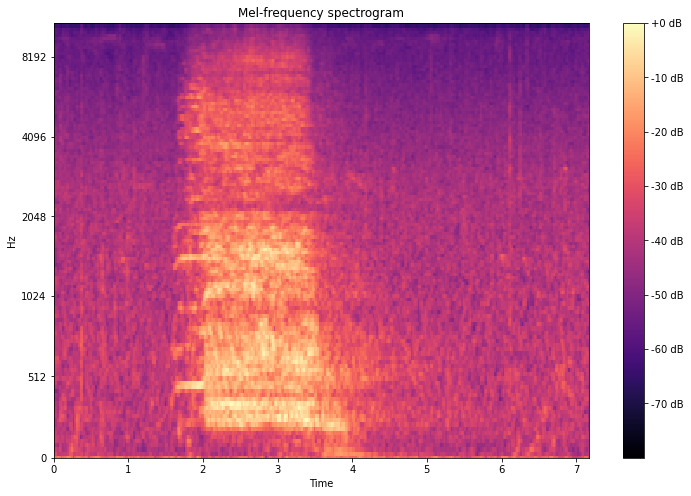

In [25]:
import librosa
import librosa.display
# Testing with a single wav file
audio_data = f'{RAW_FOLDER}/opp_329_ro.wav'
#
#ipd.Audio(audio_data,rate=60)

y, sr = librosa.load(audio_data)

# Passing through arguments to the Mel filters
S = librosa.feature.melspectrogram(y=y, sr=sr)#, n_mels=512,
                                   # fmax=8000)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr, ax=ax)
fig.colorbar(img, ax=ax, format='%+0.0f dB')
ax.set(title='Mel-frequency spectrogram')

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=512)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr, ax=ax)
fig.colorbar(img, ax=ax, format='%+0.0f dB')
ax.set(title='Mel-frequency spectrogram')

Here we are exploring the features provided in the measurement tab of the metadata. We will look to see if there is any apparent structure to the data by performing a PCA.

In [29]:
features_df = pd.read_excel(f"{METADATA_FOLDER}/Age-sex calls- Dzanga Bai.xlsx", sheet_name="measurements")
features_df.head()

/home/karma/.local/share/virtualenvs/capstone_project-Bcy6YRu4/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,unique_ID,call_type,call,analysis,pfc_mean,pf_max,pf_min,pf_range,loc_pfc_max,loc_pfc_min,...,pf_en,loc_pf_en,loc_25_en,loc_50_en,loc_75_en,f1,form_space,total_dur,agg_entrop,avg_entro
0,opp_330_ru,ru,ru,f0,46.432141,52.73438,37.10938,15.62500,25.581395,95.348837,...,158.20312,0.7603,31.821445,50.125617,71.861821,158.13,NaN,2.2290,6.45124,5.54528
1,opp_332_ru,ru,ru,f0,28.325990,33.20312,18.55469,14.64843,9.883721,100.000000,...,32.22656,1.1722,21.280870,33.945099,52.941442,29.24,106.45,4.4298,5.74778,4.90156
2,opp_333_ru,ru,ru,for,22.968750,26.36719,16.60156,9.76563,30.666667,99.333333,...,26.36719,1.6079,39.191651,48.482719,61.755674,28.53,139.64,3.8424,4.46196,3.58849
3,opp_333_ru1,ru,ru,f0,25.500661,29.29688,17.57812,11.71876,11.267606,97.183099,...,29.29688,0.8288,17.779418,28.934274,46.363736,30.79,109.08,3.6576,5.26758,4.35843
4,opp_333_ru2,ru,ru,en,23.995535,26.36719,17.57812,8.78907,19.548872,100.000000,...,26.36719,1.1922,26.677396,40.108266,60.254572,25.88,100.11,3.4175,4.22392,3.60864


In [30]:
from sklearn.preprocessing import StandardScaler

# Separating out the features
# Removing text features, not clear what these are for
# call_type and call have 0 variance, analysis looks like truncated text
features_df.drop(["call_type","call","analysis"], axis=1, inplace=True)
features_df.reset_index(inplace=True)
features_df.dropna(inplace=True)
id_col = 'unique_ID'


x = features_df.loc[:, features_df.columns != id_col].values
# Separating out the target
y = features_df.loc[:,[id_col]].values
# Standardizing the features for use in PCA
x = StandardScaler().fit_transform(x)

In [31]:
x

array([[-1.72260133, -1.28248899, -1.14648827, ...,  0.82306649,
        -0.00743181, -0.03895846],
       [-1.7118764 , -1.79719586, -1.74614206, ...,  0.43615736,
        -1.46102607, -1.74243684],
       [-1.70115147, -1.55393774, -1.48914708, ...,  0.31443314,
        -0.55028848, -0.74357452],
       ...,
       [ 1.68792548,  1.54374629,  1.5947892 , ..., -1.42362799,
        -0.07521542,  0.76930088],
       [ 1.6986504 ,  0.9182461 ,  0.56681102, ..., -1.43344233,
        -1.43804341, -0.68293756],
       [ 1.70937533, -1.31295708, -1.14648827, ...,  1.01988032,
         0.2074725 , -0.1224024 ]])

Text(0, 0.5, 'cumulative explained variance')

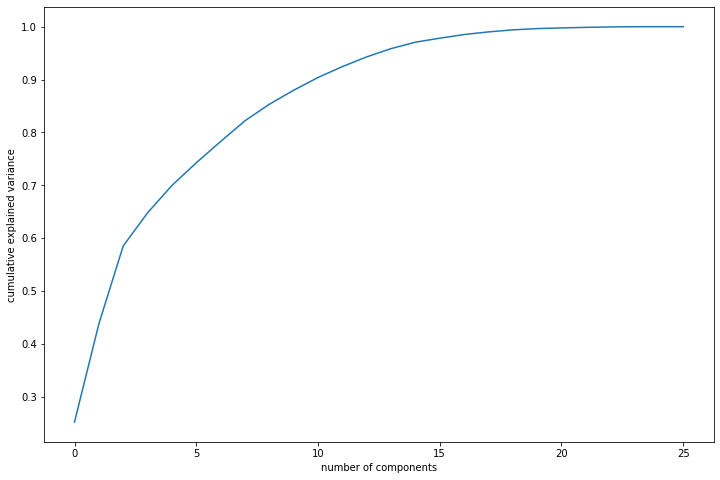

In [32]:
from sklearn.decomposition import PCA
pca = PCA().fit(x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Looks like we need about 9 principal components to account for around 90% of the variance using the provided features alone. Features may not be a good way to predict labels.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7aa10abb-09ba-4e5c-b109-d1b9cd39afe4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>